In [1]:
%load_ext google.cloud.bigquery
%config InlineBackend.figure_format = "retina" # nice looking plots

In [3]:
%%bigquery
CREATE TABLE IF NOT EXISTS richemont.orders AS (
    SELECT
        client_id,
        DATE(transaction_date) AS transaction_at,
        SUM(price_full) AS total_price,
        COUNT(product_collection) AS quantity,
    FROM richemont.orders_raw
    GROUP BY 1, 2
)

Query is running:   0%|          |

""


In [4]:
%%bigquery
SELECT * FROM richemont.orders
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,client_id,transaction_at,total_price,quantity
0,0011i00000nKQBmAAO,2015-07-24,144921.348469,1
1,0011i00000SyXWzAAR,2015-07-24,16328.631212,1
2,0011i00000YQ3gyAAD,2015-07-24,5087.757240,1
3,0011i00000nKc32AAH,2015-07-24,6719.017469,1
4,0011i00000ngUQuAAM,2015-07-24,5962.338662,1
5,0011i00000nJm1uAAH,2015-07-24,6431.062737,1
6,0011i00000YTroxAAD,2015-07-24,6631.086809,1
7,0011i00000nKc38AAH,2015-07-24,6954.251936,1
8,0011i00000SybscAAB,2015-07-24,13548.520868,1
9,0011i00000YQ1HSAA1,2015-07-24,5099.586288,1


## RFM

Source: 
- https://lifetimes.readthedocs.io/en/latest/More%20examples%20and%20recipes.html

Definitions:
- `frequency` represents the number of repeat purchases the customer has made.
- `T` represents the age of the customer in whatever time units chosen. This is equal to the duration between a customer’s first purchase and the end of the period under study.
- `recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

In [5]:
%%bigquery
CREATE OR REPLACE TABLE `richemont.rfm` AS (
WITH
max_date AS (
  SELECT MAX(transaction_at) AS max_date_
  FROM richemont.orders
)

SELECT

  client_id,
  COUNT(DISTINCT DATE(transaction_at)) - 1 as frequency,
  DATE_DIFF(MAX(transaction_at), MIN(transaction_at), DAY) as recency,
  AVG(total_price) as monetary_value,
  DATE_DIFF(max_date.max_date_, MIN(transaction_at), DAY) as T

FROM richemont.orders, max_date

GROUP BY client_id, max_date_
)

Query is running:   0%|          |

""


In [6]:
%%bigquery rfm
SELECT * FROM `richemont.rfm`

Query is running:   0%|          |

Downloading:   0%|          |

In [16]:
rfm.head()

,client_id,frequency,recency,monetary_value,T
0,0011i00000YQ1FLAA1,0,0,22028.856829,891
1,0011i00000S5sEAAAZ,0,0,10629.754096,891
2,0011i00000YQ1G5AAL,0,0,26342.052719,891
3,0011i00000YQ2TyAAL,0,0,5388.589400,891
4,0011i00000nK955AAH,1,184,17130.019921,891


In [42]:
rfm.groupby('frequency').client_id.count()

frequency
0     50088
1      2083
2       360
3       119
4        68
5        42
6        19
7        23
8         9
9        15
10        9
11        6
12        4
13        1
14        3
16        1
17        1
18        2
20        1
21        1
Name: client_id, dtype: int64

In [44]:
rfm[rfm.frequency == 21]

,client_id,frequency,recency,monetary_value,T
1063,0011i00000nLPKSAA4,21,734,18555.343688,805


In [46]:
rfm["monetary_value"].describe()

count    5.285500e+04
mean     1.073301e+04
std      1.371237e+04
min      1.184189e+03
25%      5.859495e+03
50%      8.105911e+03
75%      1.202013e+04
max      1.442532e+06
Name: monetary_value, dtype: float64

<Axes: ylabel='Frequency'>

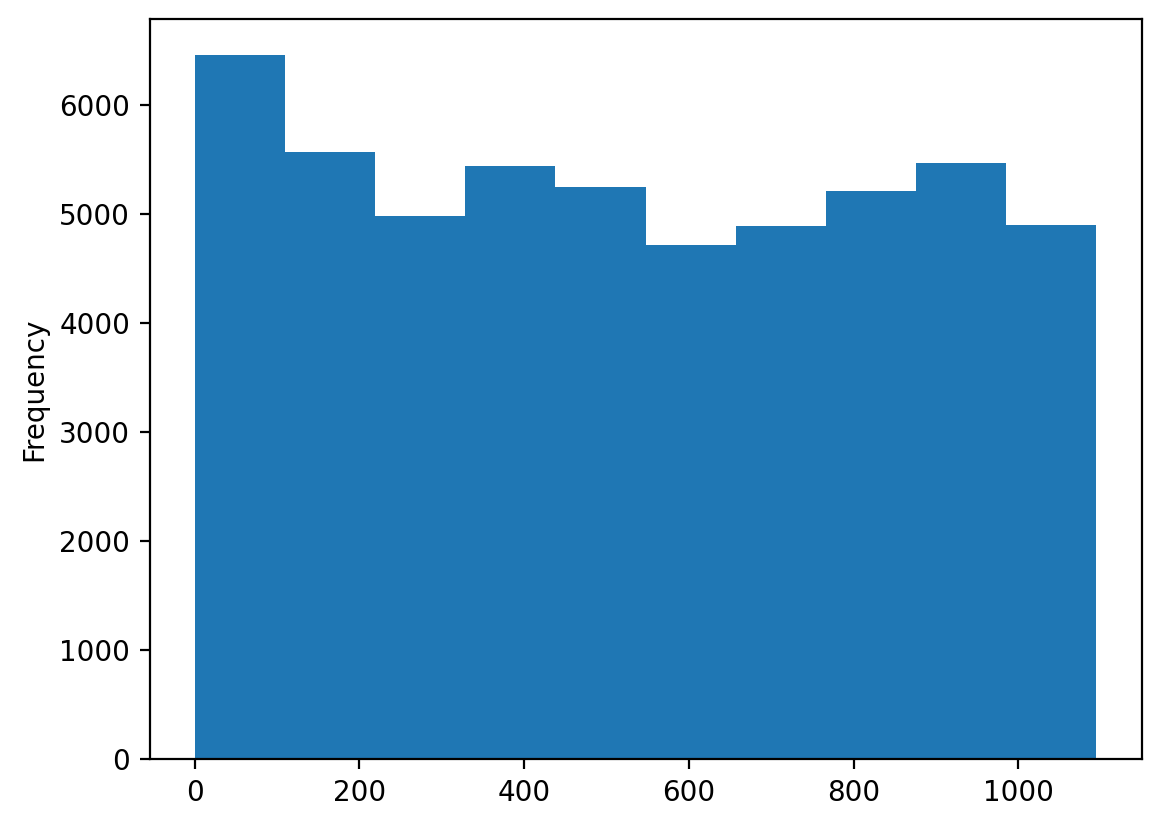

In [36]:
rfm["T"].plot(kind='hist')

## Repurchase Rate

In [31]:
(
    rfm
    .assign(has_repurchased=lambda x: x.frequency > 0)
    ['has_repurchased']
    .value_counts(normalize=True) * 100
)

has_repurchased
False    94.764923
True      5.235077
Name: proportion, dtype: Float64

Only 5% of the customers have repurchased.